In [2]:
import sys
sys.path.append("../input/weightedboxesfusion")

from ensemble_boxes import *

In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [4]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df.shape

(10, 2)

In [5]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [6]:
def get_test_transform():
    return A.Compose([
        A.Resize(width=1024, height=1024,p=1.0),
        
       
        ToTensorV2(p=1.0)
    ])

In [7]:
import gc
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
def load_net(checkpoint_path,model_name):
    if(model_name=='res101'):
        backbone = resnet_fpn_backbone('resnet101',False)
        net = FasterRCNN(backbone, num_classes=2)
        
    else:
        backbone = resnet_fpn_backbone('resnet50',False)
        net = FasterRCNN(backbone, num_classes=2)
        
        
    num_classes = 2  # 1 class (wheat) + background
    # get number of input features for the classifier
    in_features = net.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    net.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint)
    net = net.cuda()
    net.eval()

    del checkpoint
    gc.collect()
    return net

models = [
    load_net('../input/101fold0/101model0.pth','res101'),
    load_net('../input/resfold0/model0.pth','res50'),
    load_net('../input/50fold1/50model1.pth','res50'),
    load_net('../input/50fold2/50model2.pth','res50')
    ]


In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [10]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [11]:
def make_ensemble_predictions(images):
    #images = list(image.to(device) for image in images)    
    result = []
    for net in models:
        outputs = net(images)
        result.append(outputs)
    return result
w=[1,1.5,1,2]

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.4, skip_box_thr=0.3, weights=w):
    boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]) for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=w, iou_thr=iou_thr, skip_box_thr=skip_box_thr,conf_type='max')
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [12]:
torch.cuda.empty_cache()

In [13]:
results = []

for images, image_ids in test_data_loader:
    images = list(image.to(device) for image in images)
    predictions = make_ensemble_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [14]:
results

[{'image_id': 'aac893a91',
  'PredictionString': '1.4484 69 0 101 163 1.4271 694 389 125 174 1.4234 536 46 159 209 1.4162 614 917 80 105 1.3951 736 769 82 120 1.3908 557 530 130 194 1.3855 307 0 70 66 1.3833 244 86 134 144 1.3677 824 700 95 205 1.3549 25 450 99 153 1.3379 67 856 116 71 1.3279 185 574 114 195 1.2964 83 616 128 73 1.2696 319 864 77 93 1.2596 236 841 114 79 1.2414 362 532 92 82 1.1276 461 853 77 97 1.0982 374 301 99 122 0.9750 595 776 87 118 0.9136 332 672 111 142 0.5756 358 259 81 112 0.2336 824 630 88 112 0.0969 816 900 127 121 0.0966 484 975 77 48'},
 {'image_id': '51f1be19e',
  'PredictionString': '1.4619 817 89 99 75 1.3630 872 654 138 97 1.3339 354 139 78 172 1.3114 272 467 140 123 1.3031 506 467 194 96 1.2766 814 762 93 83 1.2359 611 82 155 166 1.2169 208 941 89 81 1.2068 845 271 123 189 1.2027 27 0 85 73 1.1661 767 889 138 80 1.1139 660 582 106 90 1.0983 698 920 79 79 1.0510 74 692 121 221 1.0183 0 381 50 101 0.9405 649 793 96 78 0.7635 577 596 93 105 0.7166 250 1

In [15]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df

,image_id,PredictionString
0,aac893a91,1.4484 69 0 101 163 1.4271 694 389 125 174 1.4...
1,51f1be19e,1.4619 817 89 99 75 1.3630 872 654 138 97 1.33...
2,f5a1f0358,1.3283 1 841 63 107 1.2907 945 430 77 187 1.26...
3,796707dd7,1.4137 1 454 70 73 1.3453 943 71 77 100 1.2051...
4,51b3e36ab,1.6807 707 618 262 121 1.5589 3 1 87 192 1.431...
5,348a992bb,1.4337 4 318 113 97 1.4164 539 33 74 95 1.4102...
6,cc3532ff6,1.4358 775 828 162 159 1.4142 378 0 81 100 1.4...
7,2fd875eaa,1.9541 93 2 128 60 1.4455 106 583 141 84 1.440...
8,cb8d261a3,1.4279 25 558 178 103 1.4238 24 861 76 140 1.4...
9,53f253011,1.4266 474 457 147 202 1.4146 0 397 99 113 1.4...


In [16]:
test_df.to_csv('submission.csv', index=False)

In [17]:
torch.cuda.empty_cache()

In [18]:
images, image_ids = next(iter(test_data_loader))
images = list(image.to(device) for image in images)
predictions = make_ensemble_predictions(images)



/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


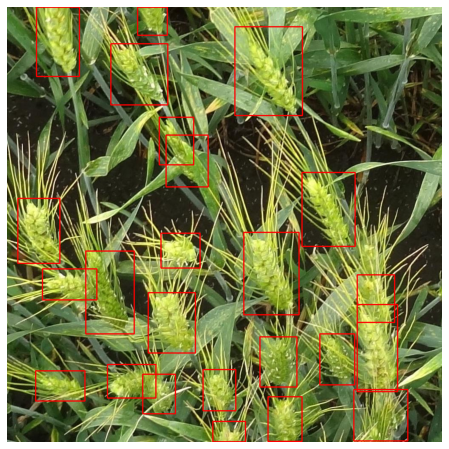

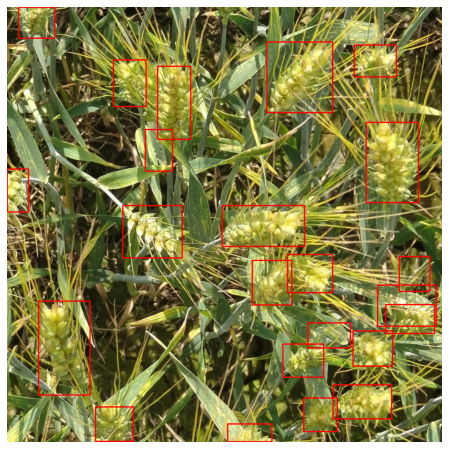

IndexError: list index out of range

In [19]:
for i in range(4):
    sample = images[i].permute(1,2,0).cpu().numpy()
    boxes, scores, labels = run_wbf(predictions, image_index=i)
    boxes = boxes.astype(np.int32).clip(min=0, max=1023)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)

    ax.set_axis_off()
    ax.imshow(sample)
    plt.show()